## Example of Visualizations
Will show:
- Plot a line plot (scatter) & bar
- Load SQL in Notebook
  - Look a sub note

In [1]:
%matplotlib inline

import sqlite3
import json
import pandas as pd #I love pandas they so cute
import matplotlib.pyplot as plt
import seaborn as sns

conn = sqlite3.connect('../data/Events.db')

## Databases = SQL (ACID) RDBMS
### Dataframes = SQL-like (Not only SQL or NoSQL)
df = pd.read_sql_query("""select a.event_id as id,
            e.event_descript as description,
            count(a.event_id) as count
    from attending a
    inner join events e on a.event_id = e.event_id
    group by a.event_id;""", conn)

# pandas version of json.dumps to file
#df.to_json('../data/eventsAttended.json')

<BarContainer object of 4 artists>

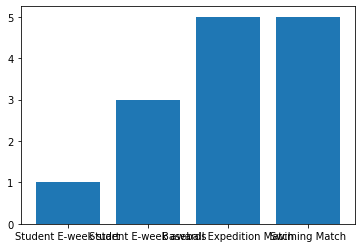

In [2]:
plt.bar(df['description'], df['count'])
## plt.show() # don't need because of inline

In [3]:
## Let's combine the above and load our DailyLabor & ServiceTimes
## And see which repairs are most ordered together
#### Market Based (affinity) Analysis w/SQL

# close old conn cause we are making a new one
conn.close()
# yep the below will create  a new DB
conn = sqlite3.connect('../data/DailyReports.db')
cur = conn.cursor()
## Then let's make our standard scripts cause this would rebuild every night
### Yep, this is batch not transaction .... still ACID
##### IS 2N-ish thought (like 1/2 N)
sqlscript = ["DROP TABLE IF EXISTS orderservices;",
    "DROP TABLE IF EXISTS dailylabors;",
    "DROP TABLE IF EXISTS servicetimes;",
    "DROP TABLE IF EXISTS pickups;",
    """CREATE TABLE servicetimes (
        service VARCHAR PRIMARY KEY,
        stime INTEGER);""",
    """CREATE TABLE dailylabors (
        order_id INTEGER PRIMARY KEY,
        date VARCHAR(12),
        day VARCHAR(5),
        price REAL,
        description VARCHAR,
        new_mem INTEGER CHECK (new_mem IN (0,1)),
        -- 0 = false or 1 = true
        member INTEGER CHECK (member IN (0,1)));""",
    """CREATE TABLE pickups (
    date VARCHAR(12) PRIMARY KEY,
    pickups INTEGER);""",
    """CREATE TABLE orderservices (
    service  VARCHAR,
    order_id INTEGER,
    FOREIGN KEY (service)
      REFERENCES servicetimes (service),
    FOREIGN KEY (order_id)
      REFERENCES dailylabors (order_id));"""
    ]

for sql in sqlscript:
    cur.execute(sql)
### so we'll execute this to show it works and does create it
##### but it seems we are moving out of SQL

In [4]:
### so now we need to process that json and build some inserts
with open("../data/ServiceTimes.json", "r") as rf:
    services = json.load(rf)

# so this would be a dict of "service name": "time"
for s,t in services.items():
    cur.execute("insert into servicetimes values(?,?);", (s,t))
# need to commit it or it rollsback
conn.commit()


In [5]:
dailies = []

with open("../data/DailyLabor.json", "r") as rf:
    raw_dailies = json.load(rf)

# so this one is a list ([]) of dictionaries
#service_insert = "insert into servicetimes values(?,?);"
for days in raw_dailies:
    for k in days:
        ## cause days is a dictionary
        ## pickups is easy so let's start with that:
        if k == "pickups":
            cur.execute("insert into pickups values (?,?);",
                        (days['date'], days[k]))
        elif k == "orders":
          ## need to loop over new dictionary
          for o in days[k]:
              cur_order = {"order_id": int(o),
                           "date": days['date'],
                           "day": days['day']
                           }
              for so in days[k][o]:
                  if so == "services":
                      for service in days[k][o][so]:

                        cur.execute("insert into orderservices values (?,?);", (service,int(o)))
                  else:
                      if so == "price":
                          ## make sure price is float (real)
                          cur_order[so] = float(days[k][o][so])
                      elif so == "member":
                          ## make sure true false is correct (1 = true, 0 = false)
                          cur_order[so] = 1 if days[k][o][so] else 0
                      elif so == "new":
                          ## make sure true false is correct (1 = true, 0 = false)
                          cur_order["new_mem"] = 1 if days[k][o][so] else 0
                      else:
                          cur_order[so] = days[k][o][so]
              dailies.append(cur_order)

In [6]:
conn.commit()

In [7]:
## not starting the dailies because that would be a mess to debug
#### Let's insert it now
insertmain = 'INSERT INTO dailylabors ({}) VALUES ({})'.format(
                ','.join(cur_order.keys()),
                ','.join(['?']*len(cur_order)))

for inserts in dailies:
    cur.execute(insertmain, tuple(inserts.values()))

In [8]:
conn.commit()

In [9]:
## plot out some interesting things
df_serv = pd.read_sql_query("""select service, count(*) as 'performed'
    from orderservices group by service;""", conn)

<BarContainer object of 14 artists>

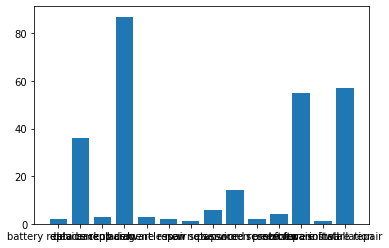

In [10]:
plt.bar(df_serv['service'], df_serv['performed'])